Database contains  ['V' 'Shed' 'MIP1a' 'MIP1b' 'MCP1' 'RANTES' 'IL6' 'TNFA' 'IFNG' 'IL10'
 'IFNA' 'IL8' 'GCSF']
Dropped 2 states.  ['V' 'MIP1a' 'MIP1b' 'MCP1' 'RANTES' 'IL6' 'TNFA' 'IFNG' 'IL10' 'IFNA'
 'IL8' 'GCSF'] remain.
Database contains  7 unique references:
Barroso (2005), Calfee (1999), Fritz(1999), Hayden (1994), Hayden (1998), Wilkinson (2012), Skoner(1999)
Database contains 20 unique, extant state/sample pairs.
V Barroso (2005), V Calfee (1999), V Fritz(1999), V Hayden (1994), V Hayden (1998), V Wilkinson (2012), MIP1a Fritz(1999), MIP1b Fritz(1999), MCP1 Fritz(1999), RANTES Fritz(1999), IL6 Fritz(1999), IL6 Hayden (1998), IL6 Skoner(1999), TNFA Fritz(1999), TNFA Hayden (1998), IFNG Fritz(1999), IL10 Fritz(1999), IFNA Hayden (1998), IL8 Hayden (1998), IL8 Skoner(1999)
Unique states: ['CD4T' 'CD8T' 'CXCL1' 'Fi' 'GMCSF' 'I1' 'IDC' 'IFNA' 'IFNB' 'IFNG' 'IL10'
 'IL12p40' 'IL12p70' 'IL1a' 'IL1b' 'IL2' 'IL6' 'MA' 'MCP1' 'MCP12' 'MI'
 'MI2' 'MIP1a' 'MIP1b' 'MT' 'N' 'NFA' 'NK' 'NKIF

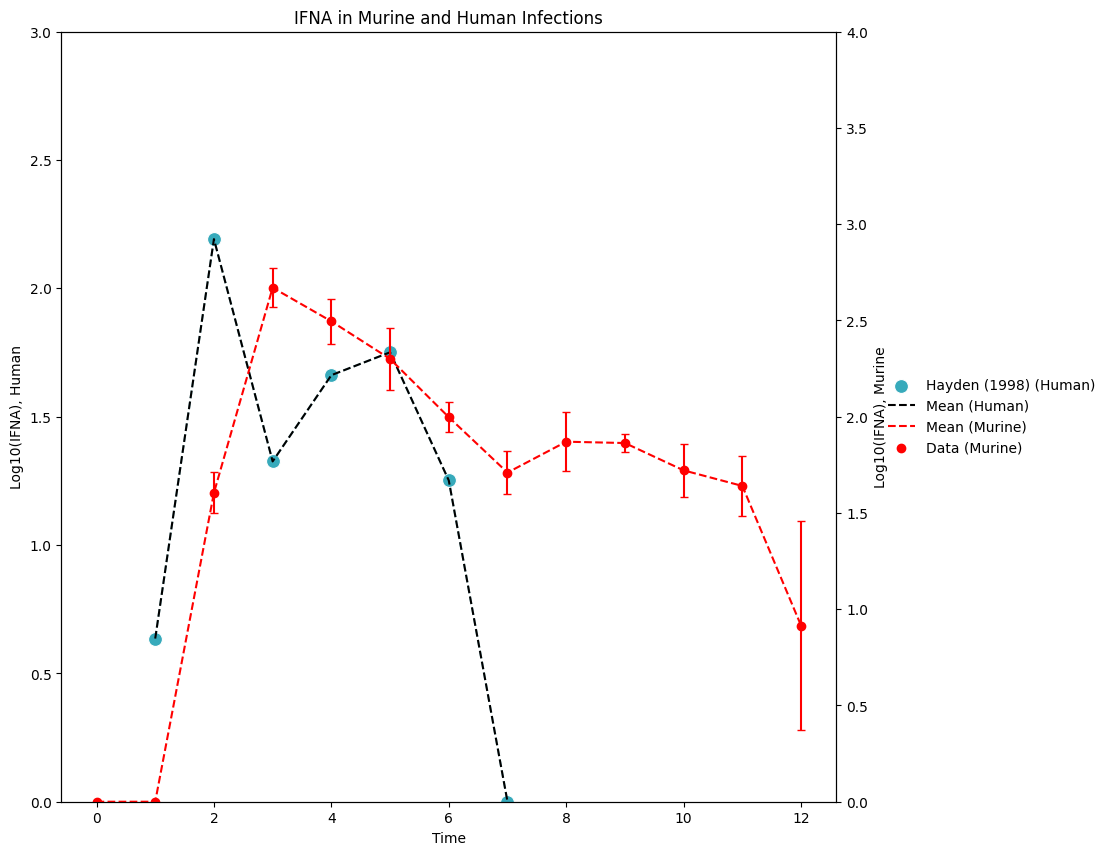

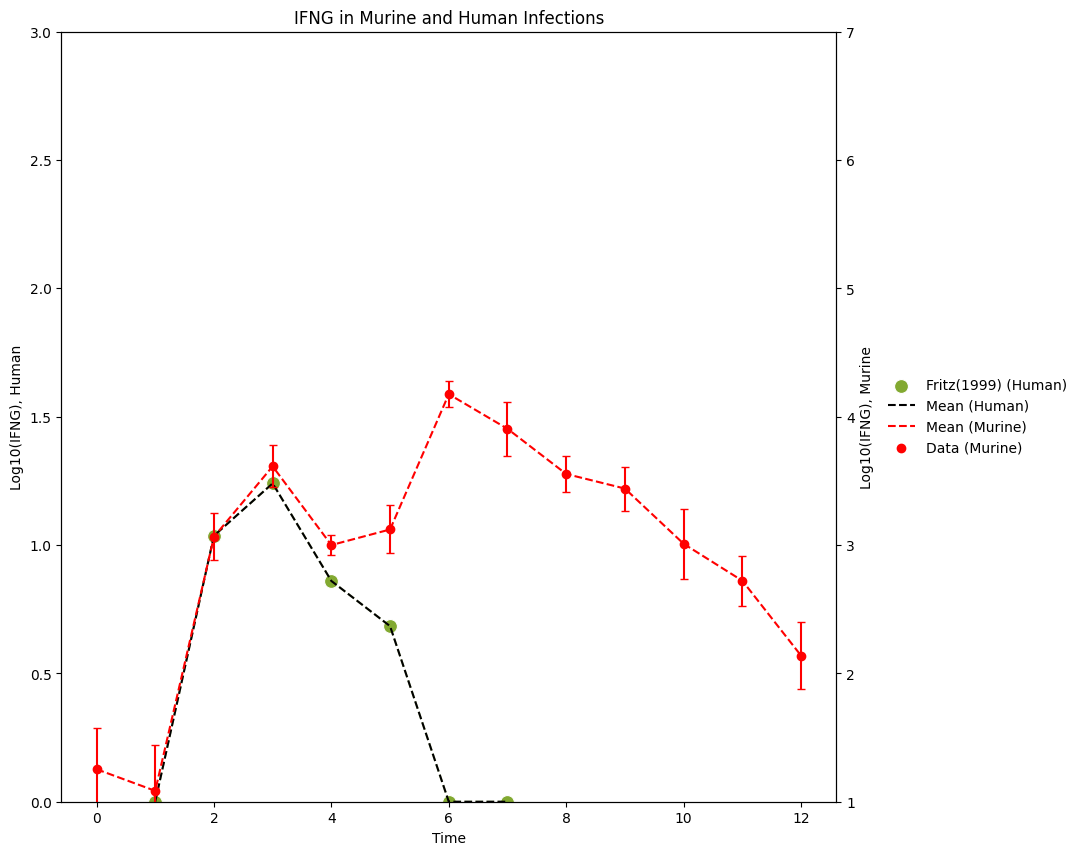

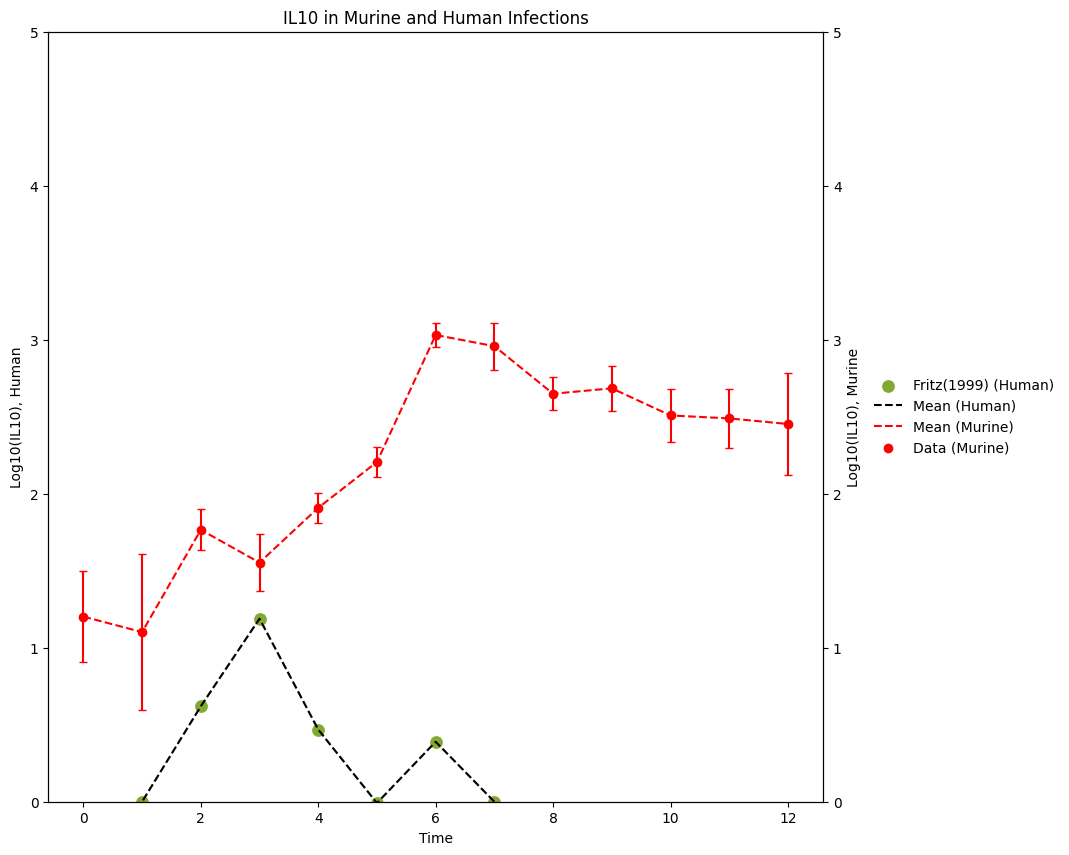

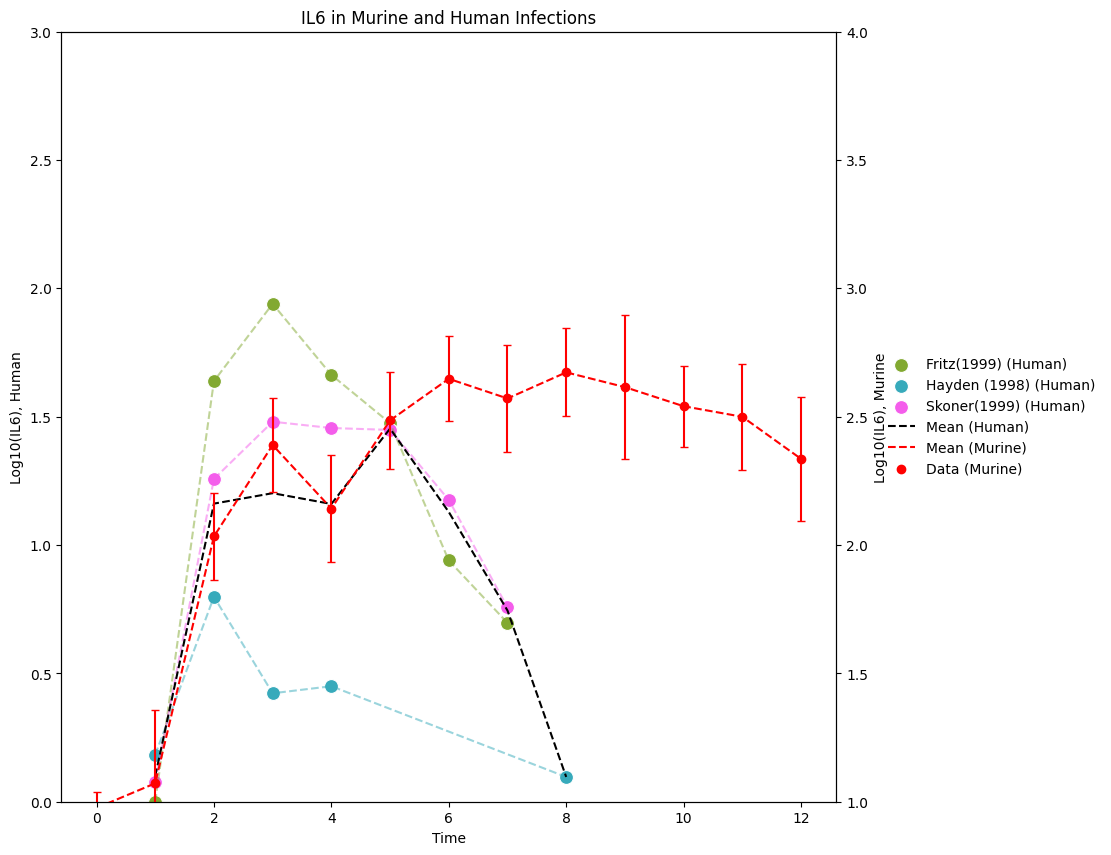

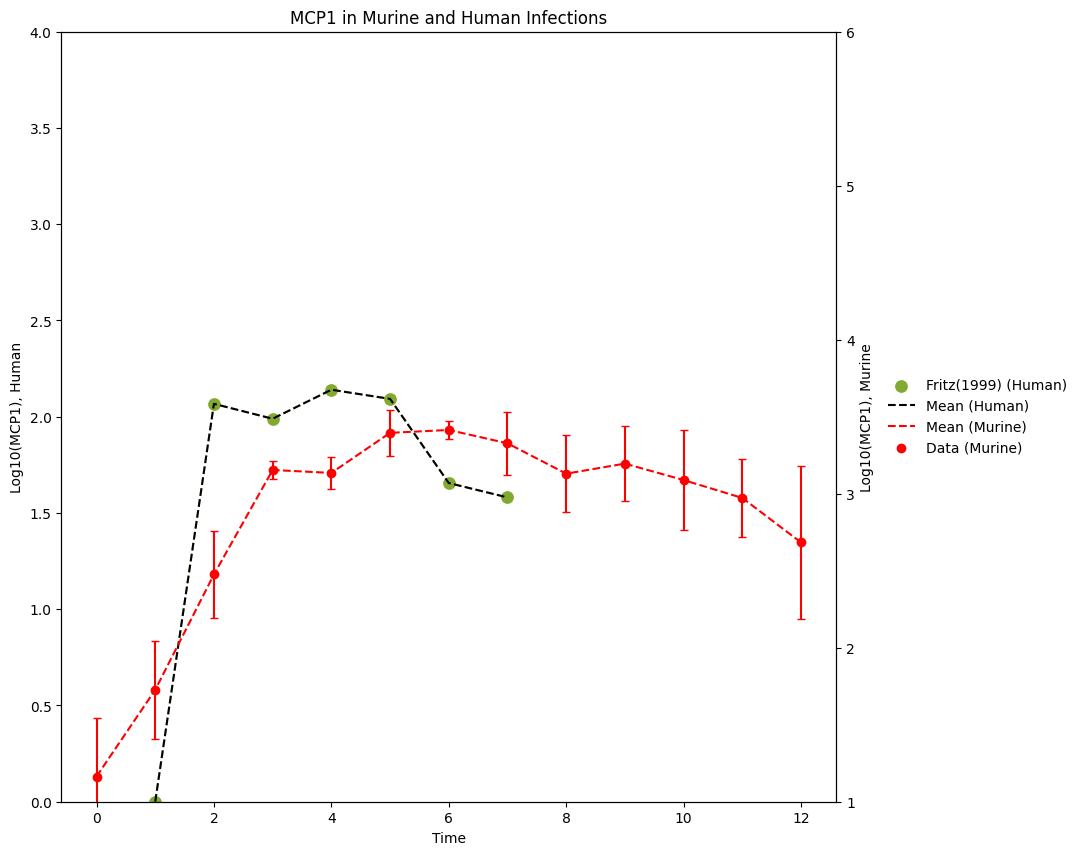

KeyError: 'MIP1a'

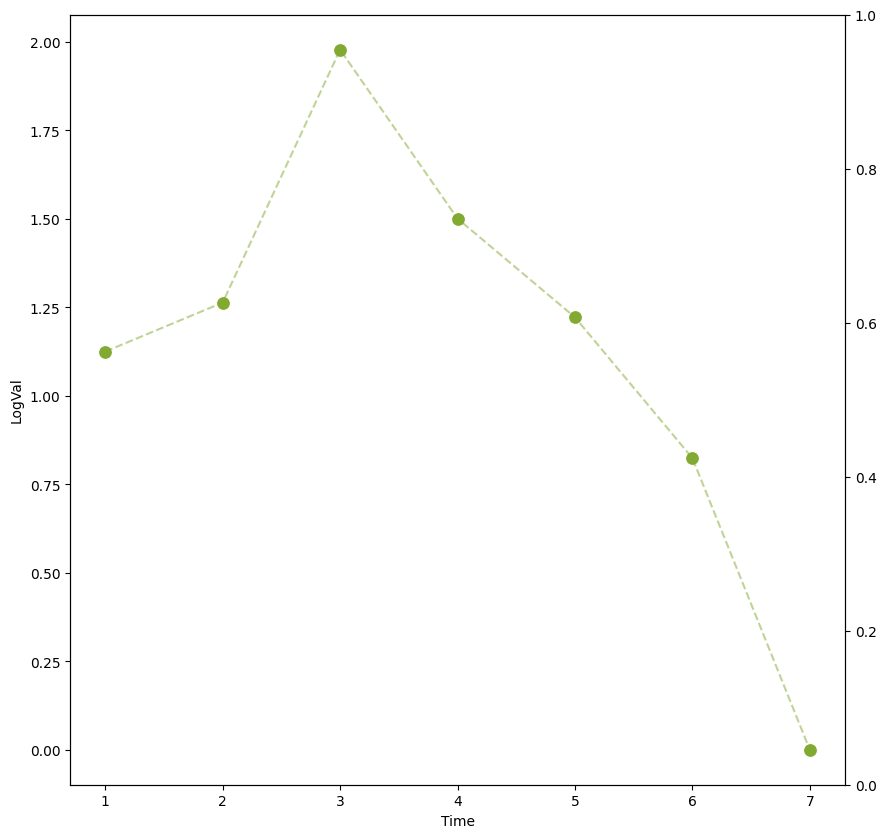

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Load data
data = pd.read_excel("../Data/Human Voluntary Data.xlsx", sheet_name='Dynamics')
data[['Error Metric', 'Error Value']] = data[['Error Metric', 'Error Value']].replace({'None': np.nan}) 

# Define a function to remove data based on an input string or list of strings and column name
def rmdata(data, string, col):
    for i in string:
        data = data[data[col] != i]
    return data

print('Database contains ', data['State'].unique()) #find and print unique states 
filter = ['NaN','Shed']
data = rmdata(data, filter, 'State')
print('Dropped', len(filter), 'states. ', data['State'].unique(), 'remain.')
filter = ['NaN', 'Serum'] # Drop Serum measurements
data = rmdata(data, filter, 'Sample')
filter = ['Hayden (1999)'] #failed measurements
data = rmdata(data, filter, 'Source')
filter = ['Night'] # PM measurements 
data = rmdata(data, filter, 'Condition')
references = data['Source'].unique() # get unique references (Souce)
print('Database contains ', references.shape[0], 'unique references:')
for i in references:
    print(i, end=', ' if i!=references[-1] else '\n')

states = data['State'].unique()
pairs = []

for i in states:
    for j in references:
        if data[(data['State'] == i) & (data['Source'] == j)].shape[0] > 0:
            pairs.append((i,j))
            
print('Database contains', len(pairs), 'unique, extant state/sample pairs.')
for i in pairs:
    print(i[0], i[1], end=', ' if i!=pairs[-1] else '\n')
    
n_plot = len(data['State'].unique())
palette = sns.color_palette("husl", len(references))
t_plot = [0, 12]

unique_states = np.unique(murine['State'].values)
print(f'Unique states: {unique_states}')
plotted_states = set()

# State (string), ylim(min), ylim(max) for murine axes
murine_ylims = {'V': (-1.0, 10.0), 'IL6': (1.0, 4.0), 'IFNG': (1.0, 7.0), 'MCP1': (1.0, 6.0), 'TNFA': (0.5, 4.0), 'IFNA': (0.0, 4.0), 'IL10': (0.0, 5.0), 'IL10': (0.0, 5.0), 'IL10': (0.0, 5.0)} 
human_ylims = {'V': (-1.0, 5.0), 'IL6': (0.0, 3.0), 'IFNG': (0.0, 3.0), 'MCP1': (0.0, 4.0), 'TNFA': (0.0, 4.0), 'IFNA': (0.0, 3.0), 'IL10': (0.0, 5.0), 'IL10': (0.0, 5.0), 'IL10': (0.0, 5.0)}

# Define function to calculate weighted mean and standard deviation
def calculate_weighted_stats(data, groupby_cols, val_col, weight_col):
    weighted_avg = data.groupby(groupby_cols).apply(
        lambda x: np.average(x[val_col], weights=x[weight_col])
    ).reset_index().rename(columns={0: f'Weighted_{val_col}'})
    
    weighted_std = data.groupby(groupby_cols).apply(
        lambda x: np.sqrt(np.average((x[val_col]-x[val_col].mean())**2, weights=x[weight_col]))
    ).reset_index().rename(columns={0: f'Weighted_Std_{val_col}'})
    
    return pd.merge(weighted_avg, weighted_std, on=groupby_cols)

# Calculate weighted mean/std for human and murine data
human = calculate_weighted_stats(data, ['State', 'Time'], 'LogVal', 'Patients')
murine_melted = data_murine.melt(id_vars=['Time', 'SampleID'], var_name='State', value_name='LogVal')
murine = calculate_weighted_stats(murine_melted, ['State', 'Time'], 'LogVal', 'SampleID')

# Create a directory for the plots if it doesn't exist
output_dir = "plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Plotting
states = human['State'].unique()
for state in states:
    if state not in murine['State'].values:
        continue

    plt.figure(figsize=(10, 10))
    ax = plt.gca()  # Get the current Axes instance on the current figure
    ax2 = ax.twinx()  # Create a twin Axes sharing the xaxis

    for source in data['Source'].unique():
        source_data = data[(data['State'] == state) & (data['Source'] == source)]
        if not source_data.empty:
            color = palette[list(data['Source'].unique()).index(source)]
            sns.scatterplot(data=source_data, x='Time', y='LogVal', ax=ax, color=color, label=f'{source} (Human)', s=100, legend=False)
            sns.lineplot(data=source_data, x='Time', y='LogVal', ax=ax, color=color, linestyle='--', alpha=0.5, legend=False)
    ax.set_ylim(human_ylims[state])

    # Plot weighted average for human data
    human_state_data = human[human['State'] == state]
    ax.plot(human_state_data['Time'], human_state_data['Weighted_LogVal'], '--', color='black', label='Mean (Human)')

    # Plot murine data
    murine_state_data = murine[murine['State'] == state]
    sns.lineplot(data=murine_state_data, x='Time', y='Weighted_LogVal', ax=ax2, color='red', linestyle='--', label='Mean (Murine)')
    ax2.scatter(murine_state_data['Time'], murine_state_data['Weighted_LogVal'], color='red', label='Data (Murine)')
    ax2.errorbar(murine_state_data['Time'], murine_state_data['Weighted_LogVal'], yerr=murine_state_data['Weighted_Std_LogVal'], fmt='none', ecolor='red', capsize=3)
    ax2.set_ylim(murine_ylims[state])

    plt.xlabel('Time')
    ax.set_ylabel(f'Log10({state}), Human')
    ax2.set_ylabel(f'Log10({state}), Murine')
    plt.title(f'{state} in Murine and Human Infections')

    # Get the legend handles and labels
    handles, labels = [], []
    for ax in [ax, ax2]:
        for h, l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    # Create a single legend
    ax2.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

    plt.show()
   
    #filename = f"{state}_combined_plot.svg".replace(' ', '_').replace('(', '').replace(')', '')
    #filepath = os.path.join(output_dir, filename)
    #plt.savefig(filepath, format='svg', bbox_inches='tight')
    #plt.close()

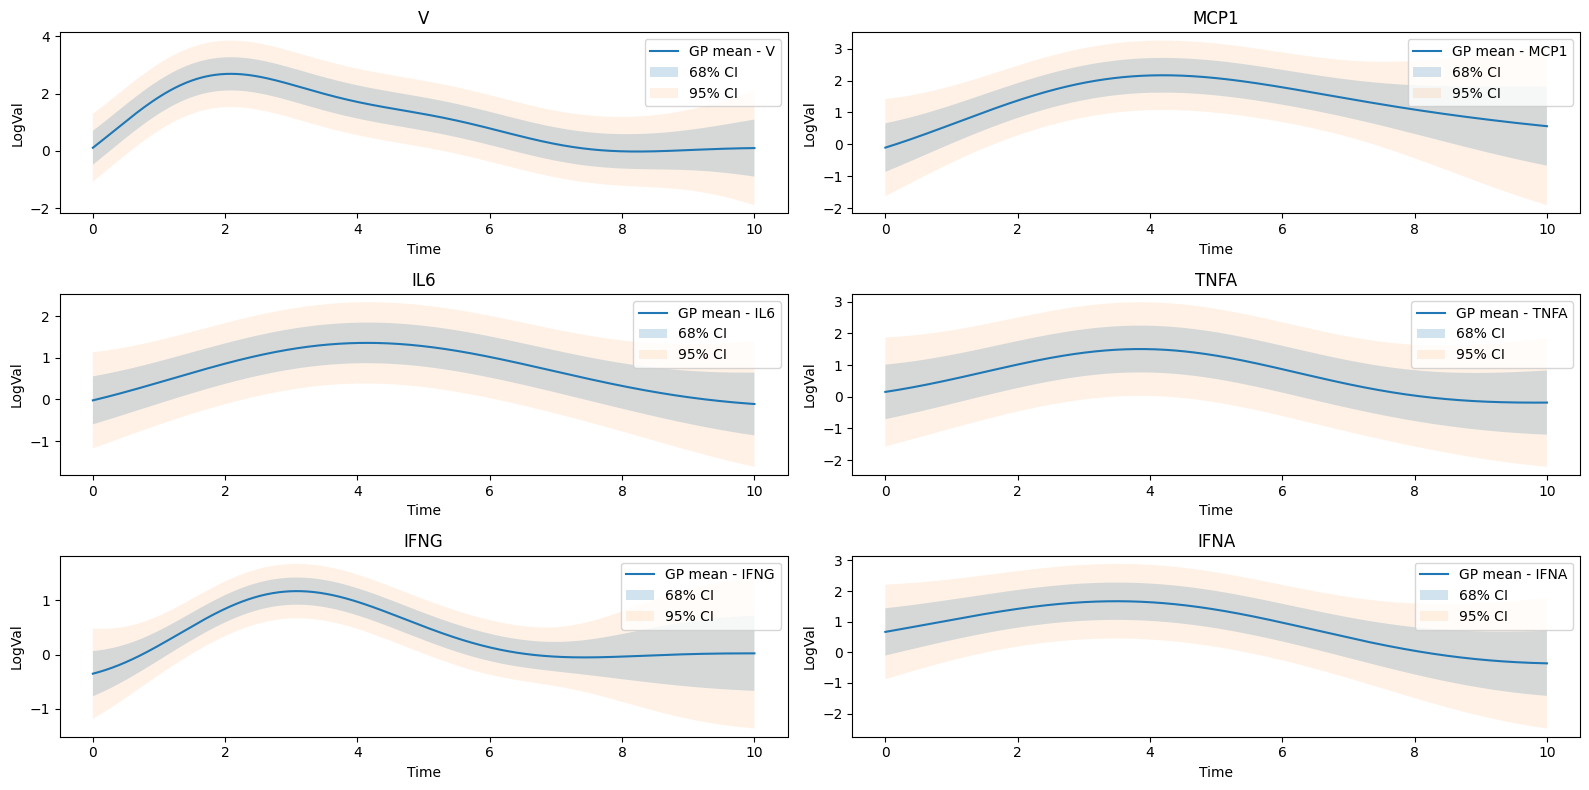

In [113]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

def fit_gp(X, y):
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X, y)
    return gp

state_models = {}
for state in states:
    state_data = data[data['State'] == state]
    X = state_data[['Time']].values
    y = state_data['LogVal'].values
    gp_model = fit_gp(X, y)
    state_models[state] = gp_model
    
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
axs = axs.flatten()
time_range = np.linspace(t_plot[0], t_plot[1], 1000)  # Define the time range for predictions

for i, state in enumerate(states):
    gp_model = state_models[state]
    # Generate predictions
    X_pred = time_range.reshape(-1, 1)
    y_mean, y_std = gp_model.predict(X_pred, return_std=True)

    # Plotting
    ax = axs[i]
    ax.plot(time_range, y_mean, label=f'GP mean - {state}')
    ax.fill_between(time_range, y_mean - y_std, y_mean + y_std, alpha=0.2, label='68% CI')
    ax.fill_between(time_range, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.1, label='95% CI')
    ax.set_title(state)
    ax.set_xlabel('Time')
    ax.set_ylabel('LogVal')
    ax.legend()

plt.tight_layout()
plt.show()